In [96]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Explaining Image Classification with Vertex Explainable AI

---



<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/explainable_ai/xai_image_classification_feature_attributions.ipynb.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/explainable_ai/xai_image_classification_feature_attributions.ipynb.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/explainable_ai/xai_image_classification_feature_attributions.ipynb.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview

Vertex Explainable AI offers feature-based and example-based explanations to provide better understanding of model decision making. For feature-based explanations, Vertex Explainable AI integrates feature attributions into Vertex AI. Feature attributions indicate how much each feature in your model contributed to the predictions for each given instance. For an image classification model, when you request explanations, you get the predicted class along with an overlay for the image, showing which areas in the image contributed most strongly to the resulting prediction.

To use Vertex Explainable AI on a pre-trained or custom-trained model, you must configure certain options when you create the `Model` resource that you plan to request explanations from, when you deploy the model, or when you submit a batch explanation job. This tutorial demonstrates how to configure these options, and get and visualize explanations for online and batch predictions.

### Objective

In this tutorial, you learn how to configure feature-based explanations on a pre-trained image classification model for online and batch predictions with explanations.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex Explainable AI
- Vertex AI Prediction

The steps performed include:

- Download pretrained model from TensorFlow Hub
- Upload model for deployment
- Deploy model for online prediction
- Make online prediction with explanations
- Make batch predictions with explanations


### Dataset

In this example, you use the TensorFlow [flowers](http://download.tensorflow.org/example_images/flower_photos.tgz) dataset. The dataset contains about 3,700 photos of flowers in five sub-directories, one per class.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
# Install the packages
! pip3 install --upgrade -q google-cloud-aiplatform
! pip3 install --upgrade -q tensorflow
! pip3 install --upgrade -q tensorflow-hub

### Colab only: Uncomment the following cell to restart the kernel.

In [98]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [100]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [101]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [102]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [103]:
BUCKET_URI = "gs://your-bucket-name-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

### Import libraries

In [105]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [106]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Download pre-trained model from TensorFlow Hub

Feature attribution is supported for all types of models (both AutoML and custom-trained), frameworks (TensorFlow, scikit, XGBoost), and modalities (images, text, tabular, video).

For demonstration purposes, this tutorial uses an image model [Inception_v3](https://tfhub.dev/google/imagenet/inception_v3/classification/5) from the TensorFlow Hub. This model was pre-trained on the ImageNet benchmark dataset.
First, you download the model from the TensorFlow Hub, wrap it as a Keras layer with `hub.KerasLayer` and save the model artifacts to your Cloud Storage bucket.

In [108]:
classifier_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model)])

classifier.build([None, 224, 224, 3])

MODEL_DIR = f"{BUCKET_URI}/model"
classifier.save(MODEL_DIR)

## Upload model for deployment

Next, you upload the model to `Vertex AI` service, which will create a `Vertex AI Model` resource for your model. During upload, you need to define a serving function to convert data to the format your model expects.

### Define a serving function for image data

You define a serving function to convert image data to the format your model expects. When you send encoded data to `Vertex AI`, your serving function ensures that the data is decoded on the model server before it is passed as input to your model.

To enable `Vertex Explainable AI` in your custom models, you need to set two additional signatures from the serving function:

- `xai_preprocess`: The preprocessing function in the serving function.
- `xai_model`: The concrete function for calling the model.

In [ ]:
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(224, 224))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


m_call = tf.function(classifier.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
)

tf.saved_model.save(
    classifier,
    MODEL_DIR,
    signatures={
        "serving_default": serving_fn,
        "xai_preprocess": preprocess_fn,  # Required for XAI
        "xai_model": m_call,  # Required for XAI
    },
)

### Get the serving function signature

You get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer. The input layer name of the serving function will be used later when you make a prediction request.

In [112]:
loaded = tf.saved_model.load(MODEL_DIR)

serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)

Serving function input: bytes_inputs


### Configure explanation settings

To use `Vertex Explainable AI` with a custom-trained model, you must configure explanation settings when uploading the model. These settings include:

- `parameters`: The feature attribution method. Available methods include `shapley`, `ig`, `xrai`.
- `metadata`: The model's input and output for explanation. **This field is optional for TensorFlow 2 models. If omitted, Vertex AI automatically infers the inputs and outputs from the model**. You don't need to configure this field in this tutorial.

See [Configure feature-based explanations](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations-feature-based) for more details.

In [110]:
XAI = "ig"  # [ shapley, ig, xrai ]

if XAI == "shapley":
    PARAMETERS = {"sampled_shapley_attribution": {"path_count": 10}}
elif XAI == "ig":
    PARAMETERS = {"integrated_gradients_attribution": {"step_count": 50}}
elif XAI == "xrai":
    PARAMETERS = {"xrai_attribution": {"step_count": 50}}

parameters = aiplatform.explain.ExplanationParameters(PARAMETERS)

### Upload the model to a `Vertex AI Model` resource

Next, upload your model to a `Vertex AI Model` resource with the explanation configuration. Vertex AI provides [Docker container images](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) that you run as pre-built containers for serving predictions and explanations from trained model artifacts.

In [ ]:
MODEL_DISPLAY_NAME = "inception_v3_model_unique"
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-5:latest"

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=MODEL_DIR,
    serving_container_image_uri=DEPLOY_IMAGE,
    explanation_parameters=parameters,
)

## Deploy model for online prediction

Next, deploy your model for online prediction. You set the variable `DEPLOY_COMPUTE` to configure the machine type for the [compute resources](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute) you will use for prediction.

In [ ]:
DEPLOY_DISPLAY_NAME = "inception_v3_deploy_unique"
DEPLOY_COMPUTE = "n1-standard-4"

endpoint = model.deploy(
    deployed_model_display_name=DEPLOY_DISPLAY_NAME,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

## Make online prediction with explanations


### Download an image dataset and labels
In this example, you use the TensorFlow flowers dataset for the input data for predictions. The dataset contains about 3,700 photos of flowers in five sub-directories, one per class. You also fetch the ImageNet dataset labels to decode the predictions.


In [115]:
import pathlib

data_dir = tf.keras.utils.get_file(
    "flower_photos",
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
)

data_dir = pathlib.Path(data_dir)
images_files = list(data_dir.glob("daisy/*"))

In [114]:
labels_path = tf.keras.utils.get_file(
    "ImageNetLabels.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt",
)

imagenet_labels = np.array(open(labels_path).read().splitlines())

### Prepare image processing functions

You define some reusable functions for image processing and visualization.

In [116]:
import base64
import io
import json

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def encode_image_in_b64(image_file):
    bytes = tf.io.read_file(image_file)
    b64str = base64.b64encode(bytes.numpy()).decode("utf-8")
    return b64str


def decode_b64_image(b64_image_str):
    image = base64.b64decode(b64_image_str)
    image = io.BytesIO(image)
    image = mpimg.imread(image, format="JPG")
    return image


def decode_numpy_image(numpy_inputs):
    numpy_inputs_json = json.loads(str(numpy_inputs))
    image = np.array(numpy_inputs_json)
    return image


def show_explanation(encoded_image, prediction, feature_attributions):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    label_index = np.argmax(prediction)
    class_name = imagenet_labels[label_index]
    confidence_score = prediction[label_index]
    axs[0].set_title(
        "Prediction:[" + class_name + "] (" + str(round(confidence_score, 1)) + "%)"
    )
    original_image = decode_b64_image(encoded_image)
    axs[0].imshow(original_image, interpolation="nearest", aspect="auto")
    axs[0].axis("off")

    numpy_inputs = feature_attributions["numpy_inputs"]
    attribution_image = decode_numpy_image(numpy_inputs)
    axs[1].set_title("Feature attributions")
    axs[1].imshow(attribution_image, interpolation="nearest", aspect="auto")
    axs[1].axis("off")

    processed_image = attribution_image.max(axis=2)
    axs[2].imshow(processed_image, cmap="coolwarm", aspect="auto")
    axs[2].set_title("Feature attribution heatmap")
    axs[2].axis("off")

### Get online explanations

You send an `explain` request with encoded input image data to the `endpoint` and get predictions with explanations.

In [117]:
TEST_IMAGE_SIZE = 2

test_image_list = []
for i in range(TEST_IMAGE_SIZE):
    test_image_list.append(str(images_files[i]))

instances_list = []
for test_image in test_image_list:
    b64str = encode_image_in_b64(test_image)
    instances_list.append({serving_input: {"b64": b64str}})

response = endpoint.explain(instances_list)

### Visualize online explanations

As you request explanations on an image classification model, you get the predicted class along with an image overlay showing which pixels (integrated gradients) or regions (integrated gradients or XRAI) contributed to the prediction.

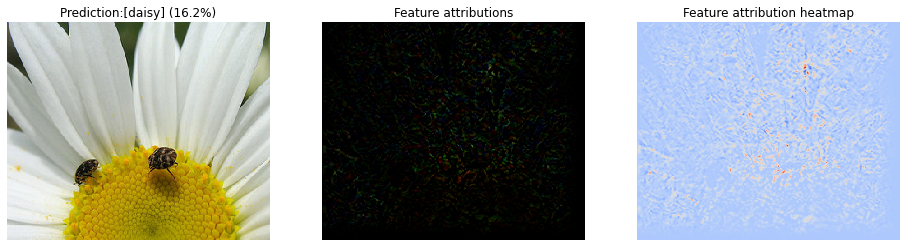

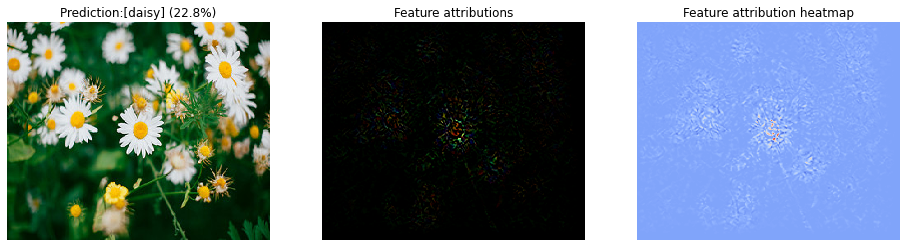

In [118]:
for i, test_image in enumerate(test_image_list):
    encoded_image = encode_image_in_b64(test_image)
    prediction = response.predictions[i]
    explanation = response.explanations[i]
    feature_attributions = dict(explanation.attributions[0].feature_attributions)

    show_explanation(encoded_image, prediction, feature_attributions)

## Make batch predictions with explanations

### Create the batch input file

You create a batch input file in JSONL format and store the input file in your Cloud Storage bucket.

In [119]:
gcs_input_uri = f"{BUCKET_URI}/test_images.json"

with tf.io.gfile.GFile(gcs_input_uri, "w") as f:
    for test_image in test_image_list:
        b64str = encode_image_in_b64(test_image)
        data = {serving_input: {"b64": b64str}}
        f.write(json.dumps(data) + "\n")

### Submit a batch prediction job

You make a batch prediction by submitting a batch prediction job with the `generate_explanation` parameter set to `True`.

In [ ]:
JOB_DISPLAY_NAME = "inception_v3_job_unique"

batch_predict_job = model.batch_predict(
    job_display_name=JOB_DISPLAY_NAME,
    gcs_source=gcs_input_uri,
    gcs_destination_prefix=BUCKET_URI,
    instances_format="jsonl",
    model_parameters=None,
    machine_type=DEPLOY_COMPUTE,
    generate_explanation=True,
)

### Get batch explanations

Next, you get the explanations from the completed batch prediction job. The results are written to the Cloud Storage output bucket you specified in the batch prediction request. You call the method `iter_outputs()` to get a list of each Cloud Storage file generated with the results.

In [121]:
bp_iter_outputs = batch_predict_job.iter_outputs()

explanation_results = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("explanation.results"):
        explanation_results.append(blob.name)

### Visualize explanations

You take one explanation result as an example and visualize the explanations. For an image classification model, you get the predicted class along with an image overlay showing which pixels (integrated gradients) or regions (integrated gradients or XRAI) contributed to the prediction.

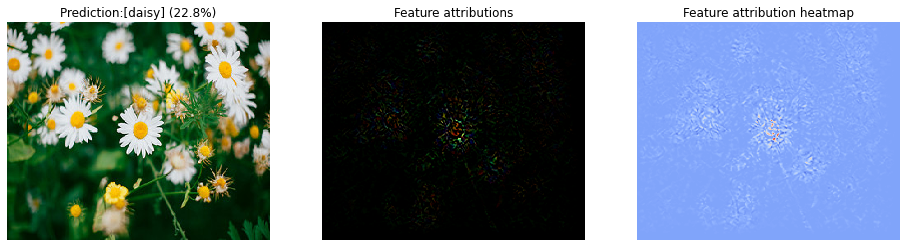

In [122]:
explanation_result = explanation_results[0]

gfile_name = f"{BUCKET_URI}/{explanation_result}"
with tf.io.gfile.GFile(name=gfile_name, mode="r") as gfile:
    result = json.loads(gfile.read())

encoded_image = result["instance"]["bytes_inputs"]["b64"]
prediction = result["prediction"]
attributions = result["explanation"]["attributions"][0]
feature_attributions = attributions["featureAttributions"]

show_explanation(encoded_image, prediction, feature_attributions)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
import os

endpoint.undeploy_all()
endpoint.delete()
model.delete()
batch_predict_job.delete()

delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI